In [1]:
import pandas as pd
import joblib
import numpy as np
import pandas as pd
from torch import nn
import torch
import os
import torch.optim as optim
import warnings
from utils import *
warnings.simplefilter('ignore')
from torch.nn import Linear,ReLU,Sigmoid
torch.cuda.is_available()
os.listdir('C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式/modelpkl')

['Critic.pkl', 'dataset.pkl', 'stream_lasso_weight.pkl']

In [2]:
os.listdir('C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式')

['#2反應槽(20200201-20200212)開車資料.csv',
 '.ipynb_checkpoints',
 'modelpkl',
 'PA_201605-2020001更新R11(20200801).csv',
 'R11註解.txt',
 'runs',
 'tag_cleaned.csv',
 'tag盤點表20200801.csv',
 'tag盤點表20200801.xlsx',
 'train_cleaned.csv',
 'yo_R11_Actor.ipynb',
 'yo_R11_API_test.ipynb',
 'yo_R11_Critic.ipynb',
 'yo_R11_ETL.ipynb',
 'yo_R11_preprocessing.ipynb',
 'yo_R11_stream_lasso.ipynb',
 '壓縮檔']

In [4]:
tag = pd.read_csv('C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式/tag_cleaned.csv')
tag_map = dict(zip(tag.TAG,tag.chinese))

# load critic , lasso_weight and data

In [5]:
critic = joblib.load('C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式/modelpkl/Critic.pkl').eval()
lasso_w = torch.FloatTensor(joblib.load('C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式/modelpkl/stream_lasso_weight.pkl'))

AttributeError: Can't get attribute 'Critic' on <module '__main__'>

In [5]:
data = joblib.load('C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式/modelpkl/dataset.pkl')
data.keys()

dict_keys(['state', 'action', 'output', 'stream', 'idx', 'mm_state', 'mm_action', 'mm_output', 'mm_stream', 'state_col', 'action_col', 'output_col', 'stream_col'])

# data iter

In [6]:
state = torch.FloatTensor(data['state'])
request = torch.FloatTensor(np.random.uniform(0,1,size=(state.shape[0],1)))
real_action = torch.FloatTensor(data['action'])
state.shape,request.shape,real_action.shape

(torch.Size([87789, 2]), torch.Size([87789, 1]), torch.Size([87789, 36, 12]))

In [7]:
train = torch.utils.data.TensorDataset(state,request,real_action)
train_iter = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)

# Construct the neural network

In [8]:
data['action'].shape

(87789, 36, 12)

In [9]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_step = data['action'].shape[1]
        self.num_sensor = data['action'].shape[2]
        self.flat_size = self.time_step*self.num_sensor
        self.fc = nn.Sequential(nn.Linear(3,128),nn.ReLU(),nn.Linear(128,self.flat_size))
        
    def forward(self,state,request):
        action = self.fc(torch.cat((state,request),dim=1))
        action = action.view(-1,self.time_step,self.num_sensor)
        return F.sigmoid(action)

In [10]:
def init_weights(m):
    if hasattr(m,'weight'):
        try:
            #torch.nn.init.xavier_uniform(m.weight)
            torch.nn.init.kaming_uniform(m.weight)
        except:
            pass
    
    if hasattr(m,'bias'):
        try:
            m.bias.data.fill_(0)
        except:
            pass

In [11]:
net = Actor()
net.apply(init_weights)

Actor(
  (fc): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=432, bias=True)
  )
)

# forward test

In [12]:
print(net(state,request).shape)

torch.Size([87789, 36, 12])


# objective

In [13]:
time_step = data['action'].shape[1]
num_sensor = data['action'].shape[2]
print(time_step, num_sensor)

36 12


In [14]:
loss_history = {}
loss_history['loss1'] = []
loss_history['loss2'] = []
loss_history['loss3'] = []
loss_history['loss4'] = []
loss_history['loss5'] = []
loss_history['loss6'] = []
loss_history['loss7'] = []
loss_history['loss8'] = []

In [15]:
def obj_function(action,state,request,real_action):
    
    # critic predict 0997(output) but not predict stream
    output, _ = critic(state.cuda(),action.cuda())
    output = output.cpu()
    
    # only use lasso_w predict stream
    batch_size = action.shape[0]
    A = torch.cat((action.reshape(batch_size,-1),state),dim=-1)
    stream = (A@lasso_w).reshape(-1,1)
    
    # 滿足使用者需求(出料等於期望出料)
    loss1 = ((request - output)**2).mean()
    
    # 最小化蒸氣量(愈小愈好)
    loss2 = (stream**2).mean()
    
    # 入料跟出料"質量平衡" #最小化單耗
    feed = action.reshape(-1,time_step,num_sensor)[:,:,0]
    loss3 = ((0.8*feed - request)**2).mean()
    loss8 = (((feed/output) - 0.9)**2).mean()
    
    # 避免鹽浴"溫差太大"
    temp_1 = action.reshape(-1,time_step,num_sensor)[:,:,4]
    temp_2 = action.reshape(-1,time_step,num_sensor)[:,:,-2]
    loss4 = ((temp_1 - temp_2)**2).mean()
    
    # 避免"變異數太大(時間維度上)"
    loss5 = action.reshape(-1,time_step,num_sensor).std(axis=1)
    loss5 = loss5.sum(axis=-1).mean(axis=0) # instance wise => batch wise
    
    #濃度盡量接近90
    loss6 = (action.reshape(-1,time_step,num_sensor)[:,:,-1] - 0.9)**2
    loss6 = loss6.mean()
    
    #避免action跟實際歷史數據差距太大
    loss7 = F.softplus((action.reshape(-1)-real_action.reshape(-1))**2 - 0.1,beta=5).mean()
    
    # 紀錄
    loss_history['loss1'].append(loss1.item())
    loss_history['loss2'].append(loss2.item())
    loss_history['loss3'].append(loss3.item())
    loss_history['loss4'].append(loss4.item())
    loss_history['loss5'].append(loss5.item())
    loss_history['loss6'].append(loss6.item())
    loss_history['loss7'].append(loss7.item())
    loss_history['loss8'].append(loss8.item())
    
    #由於最小化蒸氣量會導致入料跟著最小化會出問題 故將loss2*0
    return loss1 + 0*loss2 + 5*loss3 + loss4 + loss5 + loss6 + loss7 + 5*loss8

In [16]:
obj_function(net(state,request),state,request,real_action)

tensor(1.2104, grad_fn=<AddBackward0>)

# optimizer

In [17]:
optimizer = optim.Adam(net.parameters(),lr=1e-4)

# train loop

In [18]:
def train(net,train_iter,obj_function,optimizer,num_epochs=100):
    train_history = []
    for epoch in range(num_epochs):
        train_avg_loss = 0
        t = 0
        
        for state,request,real_action in train_iter:
            action = net(
                state,request)
            loss = obj_function(action,state,request,real_action)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_avg_loss += loss.item()
            t += 1
        
        train_avg_loss /= t
        print("epochs {} loss {:.4f}".format(epoch,train_avg_loss))
        train_history.append(train_avg_loss)
    
    # plt train loss
    plt.plot(np.array(train_history))
    plt.title('train loss')
    return net

epochs 0 loss 0.8769
epochs 1 loss 0.5834
epochs 2 loss 0.4150
epochs 3 loss 0.2997
epochs 4 loss 0.2589
epochs 5 loss 0.2407
epochs 6 loss 0.2301
epochs 7 loss 0.2230
epochs 8 loss 0.2179
epochs 9 loss 0.2141
epochs 10 loss 0.2114
epochs 11 loss 0.2093
epochs 12 loss 0.2077
epochs 13 loss 0.2064
epochs 14 loss 0.2053
epochs 15 loss 0.2043
epochs 16 loss 0.2035
epochs 17 loss 0.2027
epochs 18 loss 0.2021
epochs 19 loss 0.2014
epochs 20 loss 0.2008
epochs 21 loss 0.2003
epochs 22 loss 0.1998
epochs 23 loss 0.1993
epochs 24 loss 0.1988
epochs 25 loss 0.1984
epochs 26 loss 0.1980
epochs 27 loss 0.1976
epochs 28 loss 0.1973
epochs 29 loss 0.1969
epochs 30 loss 0.1965
epochs 31 loss 0.1962
epochs 32 loss 0.1959
epochs 33 loss 0.1956
epochs 34 loss 0.1953
epochs 35 loss 0.1951
epochs 36 loss 0.1948
epochs 37 loss 0.1945
epochs 38 loss 0.1943
epochs 39 loss 0.1941
epochs 40 loss 0.1938
epochs 41 loss 0.1936
epochs 42 loss 0.1934
epochs 43 loss 0.1932
epochs 44 loss 0.1930
epochs 45 loss 0.192

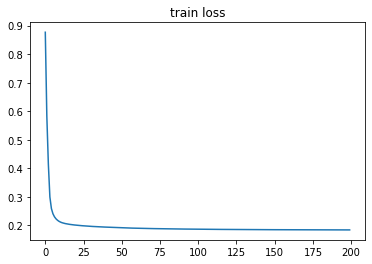

In [19]:
actor = train(net,train_iter,obj_function,optimizer,num_epochs=200)

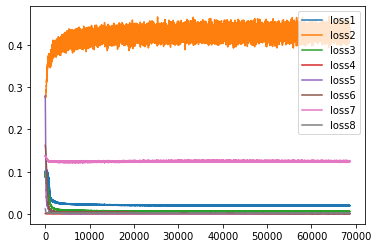

In [20]:
for k,v in loss_history.items():
    plt.plot(pd.Series(v).rolling(5).mean(),label=k)
plt.legend()
plt.show()

# build api

In [21]:
class PA_ROBOT:
    def __init__(self):
        self.mm_output = data['mm_output']
        self.mm_stream = data['mm_stream']
        self.mm_state = data['mm_state']
        self.mm_action = data['mm_action']
        self.action_col = data['action_col']
        self.tag_map = tag_map
        self.actor = actor
        self.critic = critic
        self.lasso_w = lasso_w
    
    def get_advice(self,state,request):
        
        # sacle input
        request = self.mm_output.transform([[request]])
        state = self.mm_state.transform([state])
        
        # tensor format input
        request = torch.FloatTensor([request]).reshape(-1,1)
        state = torch.FloatTensor(state)
        
        # actor forward
        action = self.actor(state,request)
        
        # critic forward but not predict stream
        output,_ = self.critic(state.cuda(),action.cuda())
        
        # lasso predict stream
        batch_size = action.shape[0]
        A = torch.cat((action.reshape(batch_size,-1),state),dim=-1)
        stream = (A@lasso_w).reshape(-1,1)
        
        # inverse transform
        output = output.detach().cpu().numpy()
        output = self.mm_output.inverse_transform(output)
        stream = stream.detach().cpu().numpy()
        stream = self.mm_stream.inverse_transform(stream)
        action = action.detach().cpu().numpy()
        action = np.array([self.mm_action.inverse_transform(i) for i in action]).squeeze(0)
        
        # create advice DataFrame
        advice = pd.DataFrame(index = self.action_col)
        advice['chinese'] = advice.index.map(self.tag_map) 
        advice['mean'] = action.mean(axis=0)
        advice['max'] = action.max(axis=0)
        advice['min'] = action.min(axis=0)
        
        # feed
        feed = advice.loc['MLPAP_FQ-0619.PV','mean']
        return advice,output,stream,feed/output[0][0],feed/stream[0][0]

In [22]:
robot = PA_ROBOT()

In [23]:
advice,output,stream,單耗,蒸氣單耗 = robot.get_advice([0.5,0.5],8000)
print('output:',output,'stream:',stream,'單耗',單耗,'蒸氣單耗',蒸氣單耗)
advice

output: [[8585.905]] stream: [[47776.707]] 單耗 0.8944842 蒸氣單耗 0.16074687


,chinese,mean,max,min
MLPAP_FQ-0619.PV,OX入料量,7679.956543,7701.177734,7649.350098
MLPAP_TJC-0627.PV,OX預熱器出口溫度,151.328049,151.607849,151.109482
MLPAP_TRC-0610.PV,空氣預熱器出口溫度,183.198715,183.858368,182.448212
MLPAP_FR-0632.PV,汽機風量,82.710709,82.941414,82.373535
MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,350.507965,350.986572,350.187653
MLPAP_PIC-0761.PV,鹽浴冷卻器(E212)出口壓力,48.539288,48.615978,48.460064
MLPAP_TJC-1721.PV,轉換式冷凝器冷油溫度,58.360004,58.560699,58.171883
MLPAP_TRC-1734.PV,轉換式冷凝器熱油溫度,180.912781,181.708572,180.166962
MLPAP_TRC-0747.PV,E220出口溫度,162.900040,163.934555,161.871841
MLPAP_TJR-0881.PV,液態冷凝器出口溫度,134.565964,135.127716,134.076401


# save

In [24]:
joblib.dump(robot,'../model/PAagent.pkl')

['../model/PAagent.pkl']